# Phân lớp dữ liệu trên mặt phẳng với mạng neuron có lớp ẩn.

Trong bài này bạn sẽ:
- Tìm hiểu về lan truyền ngược và cách hoạt động.
- Mối quan hệ giữa số lớp ẩn và độ phức tạp của cấu trúc mà mạng neuron có thể học được.
- Xây dựng một mạng neuron với 1 lớp ẩn giải bài toán phân lớp đối tượng.
- Sử dụng hàm kích hoạt không tuyến tính, ví dụ như hàm `tanh`.
- Tính hàm mất mát cross entropy.
- Thực thi lan truyền xuôi và lan truyền ngược.

## 1 - Packages ##

Những thư viện sẽ được sử dụng trong bài này.
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [sklearn](http://scikit-learn.org/stable/) provides simple and efficient tools for data mining and data analysis. 
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.

In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
from testCases_v2 import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

## 2 - Dataset ##

Đầu tiên, cùng kiểm tra dataset mà chúng ta sẽ làm việc trên đó. Đoạn code sau sẽ sinh ra một dataset gồm 2 lớp với 2 biến là X và Y.

In [2]:
X, Y = load_planar_dataset()

Biểu diễn dataset bằng matplotlib. Dữ liệu giống như một bông hoa với những điểm màu đỏ (y=0) và những điểm màu xanh (y=1). Chúng ta muốn một phân lớp để định nghĩa vùng những điểm màu đỏ và vùng những điểm màu xanh.

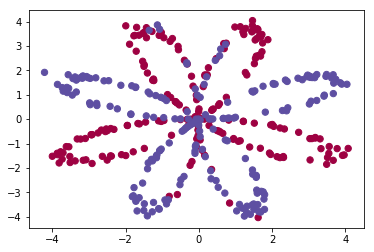

In [3]:
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y.ravel(), s=40, cmap=plt.cm.Spectral);

Chúng ta có:
- một mảng numpy/ma trận X chứa những đặc trưng (x1, x2).
- một mảng numpy/vector Y chứa nhãn (red=0, blue=1).
 

**Bài tập**: Ta có bao nhiêu mẫu luyện? Kích thước của X và Y là gì? 

**Gợi ý**: Cách lấy kích thước của một mảng numpy [(help)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html)

In [4]:
### START CODE HERE ### (≈ 3 lines of code)
shape_X = X.shape
shape_Y = Y.shape
m = X.shape[1]  # training set size
### END CODE HERE ###

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples!


**Kết quả mong đợi**:
       
<table style="width:20%">
  <tr>
    <td>shape of X</td>
    <td> (2, 400) </td> 
  </tr>
  <tr>
    <td>shape of Y</td>
    <td>(400,) </td> 
  </tr>
    <tr>
    <td>m</td>
    <td> 400 </td> 
  </tr>
  
</table>

## 3 - Hồi quy logistic đơn giản

Trước khi xây dựng một mạng neuron, hãy cũng xem phương pháp hồi quy tuyến tính thể hiện như thế nào với bài toán này. Bạn có thể sử dụng các hàm có sẵn trong thư viện `scikit-learn`. Chạy đoạn code sau để luyện một phân lớp logistic trên dataset (X,Y):

In [5]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV(cv=3);
clf.fit(X.T, Y.ravel().T);

You can now plot the decision boundary of these models. Run the code below.

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


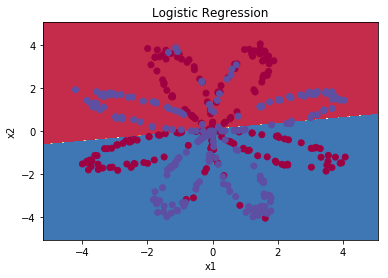

In [7]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y.ravel())
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y.ravel(),LR_predictions) + np.dot(1-Y.ravel(),1-LR_predictions))/float(Y.ravel().size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

**Đầu ra mong đợi**:

<table style="width:20%">
  <tr>
    <td>Accuracy</td>
    <td> 47% </td> 
  </tr>
  
</table>


**Nhận xét**: Dataset không thể phân lớp bằng một hàm tuyến tính, nên hồi quy logistic không thể hiện tốt trên bộ dữ liệu này. Mong là mạng neuron sẽ làm tốt hơn. Hãy bắt đầu với mạng neuron.

## 4 - Neural Network model

Bạn sẽ luyện một mạng neuron với 1 lớp ẩn.

**Mô hình của mạng neuron**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**Phương trình toán học**:

Với mỗi mẫu $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Với dự đoán trên tất cả các mẫu, bạn có thể tính hàm chi phí $J$ như sau: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Nhắc lại**: Phương pháp chung trong xây dựng mạng neuron:
    1. Định nghĩa cấu trúc của mạng ( số lượng đầu vào, số lượng lớp ẩn, số lượng đầu ra, etc). 
    2. Khởi tạo giá trị cho các tham số trong mô hình
    3. Vòng lặp:
        - Tính lan truyền xuôi (dự đoán dựa trên bộ tham số hiện tại)
        - Tính hàm mất mát
        - Lan truyền ngược để tính gradient của các tham số
        - Cập nhật các tham số (dựa trên phương pháp hướng giảm gradient)

Chúng ta thường xây dựng các hàm cho các bước từ 1 đến 3 sau đó tích hợp vào trong một hàm gọi là `nn_model()`. Một khi bạn đã xây dựng hàm `nn_model()` và luyện được bộ tham số tốt, bạn có thể dự đoán trên dữ liệu mới.

### 4.1 - Định nghĩa cấu trúc mạng ####

**Bài tập**: Định nghĩa các biến sau:
    - n_x: kích thước dữ liệu đầu vào
    - n_h: kích thước của lớp ẩn (gán giá trị là 4)
    - n_y: kích thước của dữ liệu đầu ra

**Gợi ý**: Sử dụng kích thước của X và Y để tìm n_x và n_y. Gán giá trị cho kích thước lớp ẩn là 4.

In [8]:
# GRADED FUNCTION: layer_sizes

def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    ### START CODE HERE ### (≈ 3 lines of code)
    n_x = X.shape[0] # size of input layer
    n_h = 4
    n_y = Y.shape[0] # size of output layer
    ### END CODE HERE ###
    return (n_x, n_h, n_y)

In [9]:
X_assess, Y_assess = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_sizes(X_assess, Y_assess)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2


**Đầu ra mong muốn**:

<table style="width:20%">
  <tr>
    <td>n_x</td>
    <td> 5 </td> 
  </tr>
    <tr>
    <td>n_h</td>
    <td> 4 </td> 
  </tr>
    <tr>
    <td>n_y</td>
    <td> 2 </td> 
  </tr>
</table>

### 4.2 - Khởi tạo giá trị cho các tham số ####

**Bài tập**: Thực thi hàm `initialize_parameters()`.

**Hướng dẫn**:
- Đảm bảo đúng kích thước cho các tham số. Tham khảo hình vẽ mạng neuron nếu cần.
- Bạn sẽ khởi tạo giá trị cho các trọng số với các giá trị ngẫu nhiên. 
    - Sử dụng `np.random.randn(a,b) * 0.01` để khởi tạo ma trận với giá trị ngẫu nhiên có kích thước (a,b).
- Bạn sẽ khởi tạo giá trị 0 cho vector bias: 
    - Sử dụng `np.zeros((a,b))` để khởi tạo ma trận kích thước (a,b) chứa toàn giá trị 0.

In [10]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.

    
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    ### END CODE HERE ###
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [11]:
n_x, n_h, n_y = initialize_parameters_test_case()

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


**Đầu ra mong muốn**:

<table style="width:90%">
  <tr>
    <td>W1</td>
    <td> [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]] </td> 
  </tr>
  
  <tr>
    <td>b1</td>
    <td> [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]] </td> 
  </tr>
  
  <tr>
    <td>W2</td>
    <td> [[-0.01057952 -0.00909008  0.00551454  0.02292208]]</td> 
  </tr>
  

  <tr>
    <td>b2</td>
    <td> [[ 0.]] </td> 
  </tr>
  
</table>



### 4.3 - Vòng lặp ####

**Bài tập**: Thực thi hàm `forward_propagation()`.

**Hướng dẫn**:
- Sử dụng các phương trình toán học biểu diễn mô hình mạng.
- Bạn có thể sử dụng hàm `sigmoid()` đã được import sẵn.
- Bạn có thể sử dụng hàm `np.tanh()` thuộc thư viện `numpy`.
- Các bước của thực thi:
    1. Lấy ra mỗi tham số từ biến "parameters" (là kết quả của hàm `initialize_parameters()`) bằng cách sử dụng cú pháp `parameters[".."]`.
    2. Thực thi lan truyền xuôi. Tính $Z^{[1]}, A^{[1]}, Z^{[2]}$ và $A^{[2]}$ (vector của tất cả dự đoán trên tất cả các mẫu trong tập luyện).
- Các giá trị cần cho lan truyền ngược được lưu trong biến "`cache`". Biến `cache` sẽ được sử dụng như đầu vào cho hàm lan truyền ngược.

In [12]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    ### END CODE HERE ###
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    ### START CODE HERE ### (≈ 4 lines of code)
    Z1 = np.matmul(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.matmul(W2, A1) + b2
    A2 = sigmoid(Z2)
    ### END CODE HERE ###
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [13]:
X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)

# Note: we use the mean here just to make sure that your output matches ours. 
print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))

0.26281864019752443 0.09199904522700113 -1.3076660128732143 0.21287768171914198


**Kết quả mong muốn**:
<table style="width:50%">
  <tr>
    <td> 0.262818640198 0.091999045227 -1.30766601287 0.212877681719 </td> 
  </tr>
</table>

Bây giờ bạn đã tính được $A^{[2]}$ (biến tương ứng là "`A2`"), chứa $a^{[2](i)}$ cho mỗi mẫu, bạn có thể tính hàm chi phí như sau:

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

**Bài tập**: Thực thi hàm `compute_cost()` để tính giá trị của hàm chi phí $J$.

**Hướng dẫn**:
- Có nhiều cách để thực thi hàm mất mát cross-entropy. Sau đây là cách thực thi công thức $- \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})$:
```python
logprobs = np.multiply(np.log(A2),Y)
cost = - np.sum(logprobs)                # no need to use a for loop!
```

(bạn có thể sử dụng `np.multiply()` và sau đó là `np.sum()` hoặc thay thế trực tiếp bằng `np.dot()`).  
Lưu ý rằng sử dụng `np.multiply` và sau đó là `np.sum` thì kết quả sẽ có kiểu dữ liệu `float`, trong khi sử dụng `np.dot`, thì kết quả sẽ là một mảng numpy 2 chiều.  Ta có thể sử dụng `np.squeeze()` để giảm số chiều dư thừa (trong trường hợp kết quả là một số thực, hàm sẽ giảm về ma trận 0 chiều). Ta có thể đổi kết quả về kiểu dữ liệu `float` sử dụng hàm `float()`.

In [14]:
# GRADED FUNCTION: compute_cost

def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    [Note that the parameters argument is not used in this function, 
    but the auto-grader currently expects this parameter.
    Future version of this notebook will fix both the notebook 
    and the auto-grader so that `parameters` is not needed.
    For now, please include `parameters` in the function signature,
    and also when invoking this function.]
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    
    """
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    ### START CODE HERE ### (≈ 2 lines of code)
    logprobs = np.multiply(np.log(A2), Y)
    cost = - np.sum(logprobs)
    ### END CODE HERE ###
    
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

In [15]:
A2, Y_assess, parameters = compute_cost_test_case()

print("cost = " + str(compute_cost(A2, Y_assess, parameters)))

cost = 0.6926858869721941


**Kết quả mong muốn**:
<table style="width:20%">
  <tr>
    <td>**cost**</td>
    <td> 0.693058761... </td> 
  </tr>
  
</table>

Sử dụng biến cache tính được thừ lan truyền xuôi, bạn có thể tính lan truyền ngược.

**Bài tập**: Thực thi hàm `backward_propagation()`.

**Hướng dẫn**:
Lan truyền ngược thường là phần khó nhất (nhiều toán học nhất) trong học sâu. Để giúp bạn, sau đây là hướng dẫn. Bạn sẽ muốn sử dụng 6 phương trình phía phải, vì đó là dạng đã được vector hóa.  

<img src="images/grad_summary.png" style="width:600px;height:300px;">


$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$


- Lưu ý rằng kí hiệu $*$ đại diện cho nhân ma trận theo từng phần tử.
- Kí hiệu thường được sử dụng trong học sâu:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    

- Gợi ý:
    - Để tính dZ1 bạn sẽ cần tính $g^{[1]'}(Z^{[1]})$. Vì $g^{[1]}(.)$ là hàm kích hoạt tanh, nếu $a = g^{[1]}(z)$ thì $g^{[1]'}(z) = 1-a^2$. Nên bạn có thể tính 
    $g^{[1]'}(Z^{[1]})$ sử dụng `(1 - np.power(A1, 2))`.

In [16]:
# GRADED FUNCTION: backward_propagation

def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    ### START CODE HERE ### (≈ 2 lines of code)
    W1 = parameters['W1']
    W2 = parameters['W2']
    ### END CODE HERE ###
        
    # Retrieve also A1 and A2 from dictionary "cache".
    ### START CODE HERE ### (≈ 2 lines of code)
    A1 = cache['A1']
    A2 = cache['A2']
    ### END CODE HERE ###
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    ### START CODE HERE ### (≈ 6 lines of code, corresponding to 6 equations on slide above)
    dZ2 = 1./m * (A2 - Y)
    dW2 = np.matmul(dZ2, A1.T)
    db2 = np.sum(dZ2)
    dZ1 = (1 - A1 ** 2) * np.matmul(W2.T, dZ2)
    dW1 = np.matmul(dZ1, X.T)
    db1 = np.sum(dZ1)
    ### END CODE HERE ###
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [17]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
db1 = -0.0014596199220680201
dW2 = [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
db2 = -0.16655711999999998


**Kết quả mong muốn**:



<table style="width:80%">
  <tr>
    <td>dW1</td>
    <td> [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]] </td> 
  </tr>
  
  <tr>
    <td>db1</td>
    <td>  [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]] </td> 
  </tr>
  
  <tr>
    <td>dW2</td>
    <td> [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]] </td> 
  </tr>
  

  <tr>
    <td>db2</td>
    <td> [[-0.16655712]] </td> 
  </tr>
  
</table>  

**Bài tập**: Thực thi công thức cập nhật giá trị sử dụng hướng giảm gradient. Bạn sẽ sử dụng (dW1, db1, dW2, db2) để cập nhật (W1, b1, W2, b2).

**Công thức chung của hướng giảm gradient**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ với $\alpha$ là tốc độ học và $\theta$ là một tham số.

**Mô tả**: Thuật toán hướng giảm gradient sẽ hội tụ với một tốc độ học tốt và có thể phân kì với tốc độ học tồi.

<img src="images/sgd.gif" style="width:400;height:400;"> <img src="images/sgd_bad.gif" style="width:400;height:400;">



In [18]:
# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    ### END CODE HERE ###
    
    # Retrieve each gradient from the dictionary "grads"
    ### START CODE HERE ### (≈ 4 lines of code)
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    ## END CODE HERE ###
    
    # Update rule for each parameter
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [19]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


**Kết quả mong muốn**:


<table style="width:80%">
  <tr>
    <td>W1</td>
    <td> [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]</td> 
  </tr>
  <tr>
    <td>b1</td>
    <td> [[ -1.02420756e-06]
 [  1.27373948e-05]
 [  8.32996807e-07]
 [ -3.20136836e-06]]</td> 
  </tr>
  <tr>
    <td>W2</td>
    <td> [[-0.01041081 -0.04463285  0.01758031  0.04747113]] </td> 
  </tr>
  <tr>
    <td>b2</td>
    <td> [[ 0.00010457]] </td> 
  </tr>
</table>  

### 4.4 - Tích hợp phần 4.1, 4.2 và 4.3 vào nn_model() ####

**Bài tập**: Xây dựng mô hình `nn_model()`.

**Hướng dẫn**: Mô hình mạng neuron sẽ sử dụng các hàm trước đó theo đúng thứ tự xây dựng.

In [20]:
# GRADED FUNCTION: nn_model

def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### END CODE HERE ###
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        ### START CODE HERE ### (≈ 4 lines of code)
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y, parameters)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads)
        
        ### END CODE HERE ###
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [21]:
X_assess, Y_assess = nn_model_test_case()
parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=True)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

Cost after iteration 0: 1.385354
Cost after iteration 1000: 0.000305
Cost after iteration 2000: 0.000153
Cost after iteration 3000: 0.000103
Cost after iteration 4000: 0.000077
Cost after iteration 5000: 0.000062
Cost after iteration 6000: 0.000052
Cost after iteration 7000: 0.000044
Cost after iteration 8000: 0.000039
Cost after iteration 9000: 0.000035
W1 = [[-0.70815495  1.25008499]
 [-0.83629653  1.45296074]
 [ 0.62127451 -1.12774622]
 [ 0.85460104 -1.48905466]]
b1 = [[0.00570479]
 [0.00570479]
 [0.00570479]
 [0.00570479]]
W2 = [[-2.4651285  -3.30015882  2.01136446  3.39430151]]
b2 = [[0.01097911]]


**Expected Output**:

<table style="width:90%">

<tr> 
    <td> 
        cost after iteration 0
    </td>
    <td> 
        0.692739
    </td>
</tr>

<tr> 
    <td> 
        <center> $\vdots$ </center>
    </td>
    <td> 
        <center> $\vdots$ </center>
    </td>
</tr>

  <tr>
    <td>W1</td>
    <td> [[-0.65848169  1.21866811]
 [-0.76204273  1.39377573]
 [ 0.5792005  -1.10397703]
 [ 0.76773391 -1.41477129]]</td> 
  </tr>
  
  <tr>
    <td>b1</td>
    <td> [[ 0.287592  ]
 [ 0.3511264 ]
 [-0.2431246 ]
 [-0.35772805]] </td> 
  </tr>
  
  <tr>
    <td>W2</td>
    <td> [[-2.45566237 -3.27042274  2.00784958  3.36773273]] </td> 
  </tr>
  

  <tr>
    <td>b2</td>
    <td> [[ 0.20459656]] </td> 
  </tr>
  
</table>  

### 4.5 Predictions

**Bài tập**: Sử dụng mô hình để xây dựng hàm `predict()`. Sử dụng lan truyền xuôi để dự đoán.

**Gợi ý**:

$y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  


In [30]:
# GRADED FUNCTION: predict

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    A2, cache = forward_propagation(X, parameters)
    predictions = np.piecewise(A2, [A2 > 0.5, A2 <= 0.5], [1, 0])
    ### END CODE HERE ###
    
    return predictions

In [31]:
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 0.6666666666666666


**Đầu ra mong muốn**: 


<table style="width:40%">
  <tr>
    <td>predictions mean</td>
    <td> 0.666666666667 </td> 
  </tr>
  
</table>

Đã đến lúc để luyện mô hình và xem thể hiện trên bộ dữ liệu. Chạy đoạn code sau để kiểm tra mô hình vói 1 lớp ẩn có số $n_h$ neuron.

Cost after iteration 0: 138.613963
Cost after iteration 1000: 58.043073
Cost after iteration 2000: 53.909599
Cost after iteration 3000: 46.509936
Cost after iteration 4000: 45.072147
Cost after iteration 5000: 44.235179
Cost after iteration 6000: 43.647630
Cost after iteration 7000: 43.200790
Cost after iteration 8000: 42.844731
Cost after iteration 9000: 42.552057


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

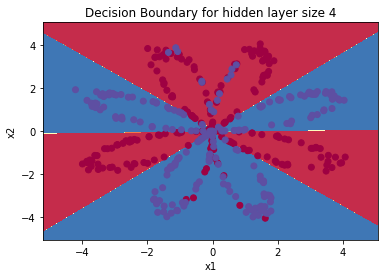

In [32]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y.ravel())
plt.title("Decision Boundary for hidden layer size " + str(4))

**Kết quả mong đợi**:

<table style="width:40%">
  <tr>
    <td>Cost after iteration 9000</td>
    <td> 0.218607 </td> 
  </tr>
  
</table>


In [33]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 90%


**Kết quả mong muốn**: 

<table style="width:15%">
  <tr>
    <td>Accuracy</td>
    <td> 90% </td> 
  </tr>
</table>

Độ chính xác cao hơn so với Logistic Regression. MÔ hình đã học được mô hình của dữ liệu! Mạng neuron có khả năng học . 

Now, let's try out several hidden layer sizes.

### 4.6 - Tinh chỉnh kích thước lớp ẩn ###

Chạy đoạn code sau. Có thể mất 1-2 phút. Bạn sẽ quan sát thấy sự khác biệt trong hành vi của mô hình với kích thức lớp ẩn khác nhau.

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 91.25 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 90.0 %
Accuracy for 20 hidden units: 91.5 %
Accuracy for 50 hidden units: 92.0 %


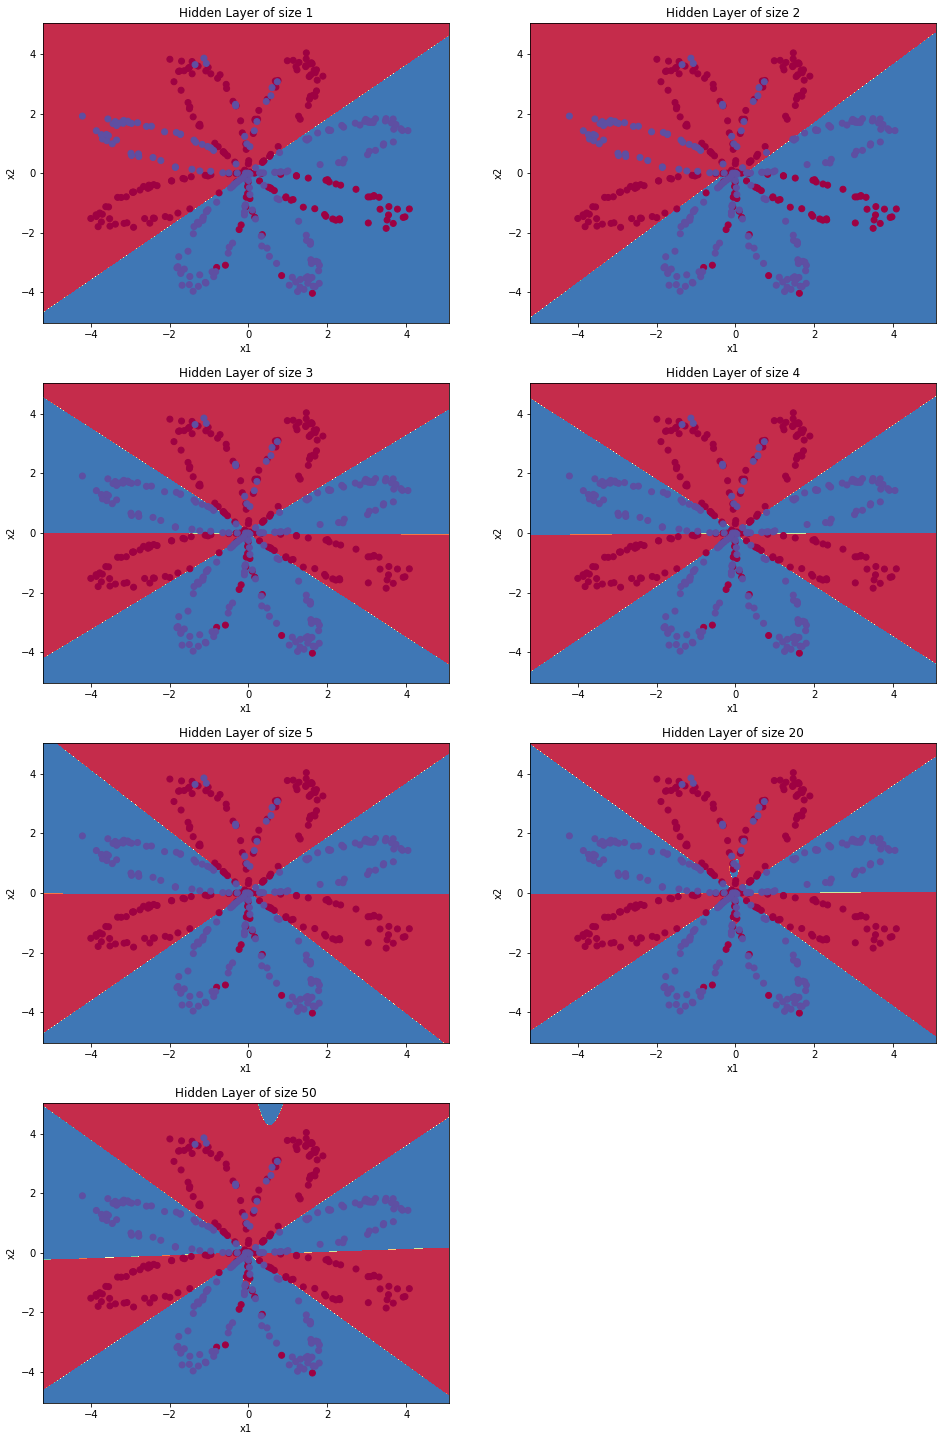

In [35]:
# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y.ravel())
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

**Nhận xét**:
- Mô hình lớn hơn (với kích thước lớp ẩn lớn hơn) có khả năng khớp dữ liệu luyện tốt hơn, cuối cùng mô hình lớn nhất overfit trên dữ liệu. 
- Số kích thước tốt nhất nằm trong khoảng `n_h=5`.
- Bạn sẽ được học về regularization, cách để sử dụng mô hình lớn hơn mà không bị overfit.

**Câu hỏi tùy chọn**:


- Điều gì sẽ xảy ra khi bạn thay hàm kích hoạt tanh bằng hàm kích hoạt sigmoid hoặc ReLU?
- Thay đổi các learing_rate khác nhau, chuyện gì xảy ra?
- Nếu thay đổi dataset thì sao? (Xem phần 5 bên dưới)

## 5) Thể hiện trên dataset khác.

Nếu bạn muốn, bạn có thể chạy lại toàn bộ notebook với các bộ dữ liệu sau.

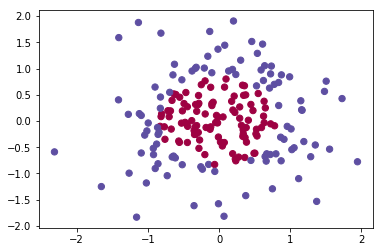

In [39]:
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### START CODE HERE ### (choose your dataset)
dataset = "gaussian_quantiles"
### END CODE HERE ###

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y.ravel(), s=40, cmap=plt.cm.Spectral);

Reference:
- http://scs.ryerson.ca/~aharley/neural-networks/
- http://cs231n.github.io/neural-networks-case-study/